# Introduction to Natural Language Processing

In this notebook, we'll go over the Word2Vec skip-gram model.

The skip-gram Word2Vec model predicts the context words from a given word.

In [2]:
import sys
print(sys.version)   # check python version; using 3.5 for tensorflow

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


In [5]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import nltk
from matplotlib import pylab
from six.moves import range
from sklearn.manifold import TSNE

In [6]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups(subset='train',
                          categories=('rec.autos',
                             'rec.motorcycles',
                             'rec.sport.baseball',
                             'rec.sport.hockey'),
                          remove=('headers', 'footers', 'quotes'))
ltokens = [nltk.word_tokenize(doc) for doc in news.data]
# convert list of list of tokens (ltokens) into a list of tokens
import itertools
words = list(itertools.chain.from_iterable(ltokens))

In [7]:
collections.Counter(words).most_common(10)

[(',', 15913),
 ('.', 15737),
 ('the', 14449),
 ('--', 11171),
 ('a', 6672),
 ('to', 6669),
 ('I', 5582),
 ('and', 5365),
 (')', 5337),
 ('of', 5049)]

Build the dictionary and replace rare words with UNK token.

In [8]:
vocabulary_size = 10000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

# Note
#     words[i] = reverse_dictionary[data[i]])
#

del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 27495], (',', 15913), ('.', 15737), ('the', 14449), ('--', 11171)]
Sample data [251, 728, 1632, 5, 0, 7361, 1258, 2, 7, 63]


Function to generate a training batch for the skip-gram model.

In [9]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['My', 'friend', 'brought', 'a', 'UNK', 'SVX', 'recently', '.']

with num_skips = 2 and skip_window = 1:
    batch: ['friend', 'friend', 'brought', 'brought', 'a', 'a', 'UNK', 'UNK']
    labels: ['My', 'brought', 'a', 'friend', 'UNK', 'brought', 'SVX', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['brought', 'brought', 'brought', 'brought', 'a', 'a', 'a', 'a']
    labels: ['friend', 'My', 'a', 'UNK', 'SVX', 'brought', 'UNK', 'friend']


Train a skip-gram model.

In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [15]:
num_steps = 200001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.144402
Nearest to can: 0.308, developed, *is*, AMA, 02, MI, mileage, laughing,
Nearest to for: Large, 0-, hard, realized, Regular, laws, intentionally, stops,
Nearest to that: obtained, 14, Best, IT175, 102.5, mood, scorers, 0.273,
Nearest to did: distance, nonsense, 58.2, Trust, Charles, hip, TSi, presume,
Nearest to A: Zezel, weight, Stillwell, Zone, confusion, Mays, Canucks, ratio,
Nearest to ``: Shadow, understanding, net, 0.458, chart, Gilles, release, post,
Nearest to UNK: California, ECHL, Keith, reconsider, saying, Built, aware, Donnelly,
Nearest to .: 1500, ***, newspapers, would, fanned, Check, Wessels, '88,
Nearest to is: collision, tape-delay, usually, Mitsubishi, stable, sarcastic, stretch, outfielders,
Nearest to team: N'T, wrist, student.business.uwo.ca, TB, offending, professional, seats, tsk,
Nearest to car: Interestingly, Born, Cohen, Michelin, sarcasm, hail, CSRAG, BDC,
Nearest to about: Committee, ADIRONDACK, Neat, favor, her, f

In [20]:
num_points = 450

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

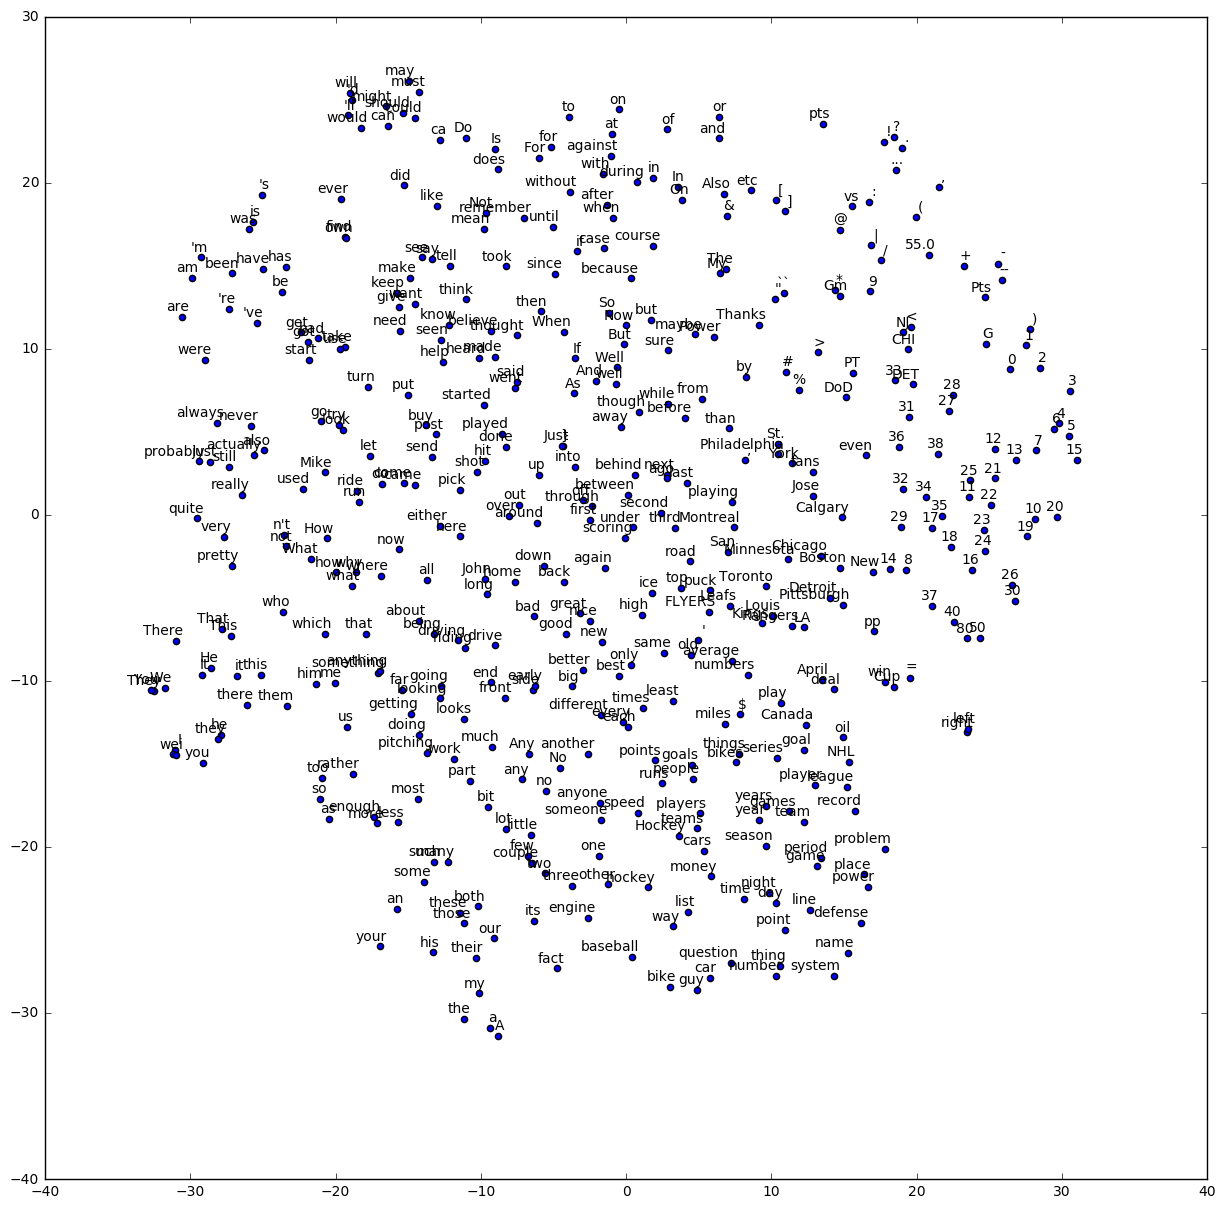

In [21]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)